# Testing implementation and accuracy of solving SRG flow equations

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ March 1, 2023

The goal of this notebook is to test our implementation of the SRG. We explore different ODE solvers, error tolerances, and different implementations (e.g., solving directly for $U(s)$, or solving with respect to $\lambda$ instead of $s$.)<br>

_Last update:_ March 29, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.integrate import ode, solve_ivp
import time

In [2]:
# Imports from scripts
from scripts.figures import interpolate_matrix, label_lambda, set_rc_parameters
from scripts.potentials import Potential
from scripts.tools import replace_periods

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Set-up

In [4]:
def rms_error_eigenvalues(eigenvalues_initial, eigenvalues_evolved):
    """Calculate the root-mean-square error of the evolved and initial
    eigenvalues.
    """
    
    # Number of eigenvalues
    N = len(eigenvalues_initial)
    
    return np.sqrt(np.sum((eigenvalues_evolved - eigenvalues_initial) ** 2) / N)

In [5]:
def unattach_weights(k_array, k_weights, matrix_weights):
    """Unattach the integration weights from a matrix."""

    # Double the length of the factor_array if coupled-channel
    if len(matrix_weights) == 2*len(k_array):
        factor_array = np.concatenate((
            np.sqrt(2 / np.pi * k_weights) * k_array,
            np.sqrt(2 / np.pi * k_weights) * k_array
        ))
    elif len(matrix_weights) == len(k_array):
        factor_array = np.sqrt(2 / np.pi * k_weights) * k_array
    else:
        raise RuntimeError("Length of matrix_weights is not compatible with "
                           "length of k_array.")
    
    # Create meshgrids to divide out factor of 2/\pi * k_i k_j \sqrt(w_i * w_j)
    row, col = np.meshgrid(factor_array, factor_array, indexing='ij')

    return matrix_weights / row / col

In [6]:
def plot_contour(
        k_array, matrix_no_weights, channel, levels_number=61,
        colorbar_limits=(-1.0,1.0), color_map='turbo', axes_limits=(0.0,10.0),
        xlabel_size=16, ylabel_size=16, label=None,
        label_location='upper right', label_size=16
):
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set contour levels
    levels = np.linspace(colorbar_limits[0], colorbar_limits[1],
                         levels_number)

    # --- Plot --- #
    if channel == '3S1-3D1':
        c = ax.contourf(k_array, k_array, matrix_no_weights[:ntot, ntot:],
                        levels, cmap=color_map, extend='both')
    elif channel == '3D1-3S1':
        c = ax.contourf(k_array, k_array, matrix_no_weights[ntot:, :ntot],
                        levels, cmap=color_map, extend='both')
    elif channel == '3D1-3D1':
        c = ax.contourf(k_array, k_array, matrix_no_weights[ntot:, ntot:],
                        levels, cmap=color_map, extend='both')
    else:
        c = ax.contourf(k_array, k_array, matrix_no_weights[:ntot, :ntot],
                        levels, cmap=color_map, extend='both')

    # --- Axes limits --- #
    ax.set_xlim(axes_limits)
    ax.set_ylim(axes_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$k'$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=ylabel_size)
    
    # --- Adjust axes --- #
    # Switch x-axis label from bottom to top
    ax.xaxis.set_label_position('top')
    ax.tick_params(labeltop=True, labelbottom=False)
    # Invert y-axis
    ax.invert_yaxis()
    
    # --- Colorbar --- #
    # Colorbar location (left, bottom, width, height)
    cbar_ax = f.add_axes((1.0, 0.15, 0.1, 0.7))
    # Set colorbar ticks
    levels_ticks = np.linspace(colorbar_limits[0], colorbar_limits[1], 9)
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks, format='%.2e')
    
    # --- Label contour plot --- #
    if label is not None:
        ax.add_artist(
            AnchoredText(label, loc=label_location, prop=dict(size=label_size))
        )

In [7]:
def run_srg(
        kvnn, channel, generator, lambda_array, kmax=15.0, kmid=3.0, ntot=120,
        solver='ode', method='BDF', atol=1e-10, rtol=1e-10, wrt='s', save=True
):
    
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    H_initial_weights = potential.load_hamiltonian()
    
    if solver == 'ode':
    
        # This will only evolve w.r.t. \lambda and using BDF
        d = srg_evolve_wrt_lambda(
            H_initial_weights, lambda_array, lambda_initial=20.0, atol=atol,
            rtol=rtol
        )
        
    elif solver == 'solve_ivp':
        
        # Evolve w.r.t. to s
        if wrt == 's':
        
            d = srg_evolve_solve_ivp(
                H_initial_weights, lambda_array, method=method, atol=1e-10,
                rtol=1e-10, wrt='s'
            )
        
        # Evolve w.r.t. to \lambda
        else:
            
            d = srg_evolve_solve_ivp(
                H_initial_weights, lambda_array, method=method, atol=1e-10,
                rtol=1e-10, wrt='lambda'
            )
            
    elif solver == 'U':
        
        d = srg_evolve_U_lambda(
            H_initial_weights, lambda_array, lambda_initial=20.0, atol=1e-10,
            rtol=1e-10
        )
            
    else:
        
        raise RuntimeError("Input either 'ode' or 'solve_ivp' as the solver.")
    
    # Save each matrix in /test_srg using np.savetxt
    if save:
        
        for ilamb in lambda_array:
            
            if solver == 'U':
                
                file_name = (
                    f"H_evolved_kvnn_{kvnn}_{channel}_{generator}_lamb_{ilamb}"
                    f"_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{solver}_{method}"
                    f"_wrt_{wrt}"
                )
            
                np.savetxt("./test_srg/" + replace_periods(file_name) + ".txt",
                           d[ilamb]['H'])
                
                file_name = (
                    f"U_kvnn_{kvnn}_{channel}_{generator}_lamb_{ilamb}"
                    f"_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{solver}_{method}"
                    f"_wrt_{wrt}"
                )
            
                np.savetxt("./test_srg/" + replace_periods(file_name) + ".txt",
                           d[ilamb]['U'])
                
            else:
                
                file_name = (
                    f"H_evolved_kvnn_{kvnn}_{channel}_{generator}_lamb_{ilamb}"
                    f"_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{solver}_{method}"
                    f"_wrt_{wrt}"
                )
            
                np.savetxt("./test_srg/" + replace_periods(file_name) + ".txt",
                           d[ilamb])
    
    return d

In [8]:
def load_H_evolved(
        kvnn, channel, generator, lamb, kmax=15.0, kmid=3.0, ntot=120,
        solver='ode', method='BDF', atol=1e-10, rtol=1e-10, wrt='s'
):
    """Load evolved Hamiltonian."""
    
    if solver == 'U':
        
        H_file_name = (
            f"H_evolved_kvnn_{kvnn}_{channel}_{generator}_lamb_{lamb}_kmax"
            f"_{kmax}_kmid_{kmid}_ntot_{ntot}_{solver}_{method}_wrt_{wrt}"
        )
            
        H_evolved = np.loadtxt("./test_srg/" + replace_periods(H_file_name)
                               + ".txt")
                
        U_file_name = (
            f"U_kvnn_{kvnn}_{channel}_{generator}_lamb_{lamb}_kmax_{kmax}"
            f"_kmid_{kmid}_ntot_{ntot}_{solver}_{method}_wrt_{wrt}"
        )
            
        U_evolved = np.loadtxt("./test_srg/" + replace_periods(U_file_name)
                               + ".txt")
        
        return H_evolved, U_evolved
        
    else:
        
        file_name = (
            f"H_evolved_kvnn_{kvnn}_{channel}_{generator}_lamb_{lamb}_kmax"
            f"_{kmax}_kmid_{kmid}_ntot_{ntot}_{solver}_{method}_wrt_{wrt}"
        )
        H_evolved = np.loadtxt("./test_srg/" + replace_periods(file_name)
                               + ".txt")
    
        return H_evolved

In [9]:
# kvnn = 6  # AV18
kvnn = 111  # SMS N4LO 450 MeV
# channel = '1S0'
channel = '3S1'
kmax, kmid, ntot = 15.0, 3.0, 120
# kmax, kmid, ntot = 30.0, 4.0, 120  # Different mesh for AV18
generator = 'Wegner'
lamb = 1.35
# lamb = 2.0
# lamb = 3.0

potential = Potential(kvnn, channel, kmax, kmid, ntot)

In [10]:
# Initial Hamiltonian with integration factors attached [MeV]
H_initial_weights = potential.load_hamiltonian()
eigenvalues_init, _ = la.eigh(H_initial_weights)

In [11]:
# Get momentum mesh
k_array, k_weights = potential.load_mesh()

## Test calculation of the SRG transformation using eigenvectors

$$
U(\lambda) = \sum_\alpha \lvert \psi_\alpha(\lambda \rangle \langle \psi_\alpha(\infty) \rvert
$$

In [12]:
def get_transformation(H_initial, H_evolved):
    """
    SRG unitary transformation built out of eigenvectors of the initial and 
    evolved Hamiltonians.
    
    Parameters
    ----------
    H_initial : 2-D ndarray
        Initial Hamiltonian matrix [MeV].
    H_evolved : 2-D ndarray
        Evolved Hamiltonian matrix [MeV].
        
    Returns
    -------
    U_matrix : 2-D ndarray
        SRG unitary transformation matrix.
        
    """

    Ntot = len(H_initial)

    # Get the eigenvectors of the initial and SRG-evolved Hamiltonians
    _, vecs_initial = la.eigh(H_initial)
    _, vecs_evolved = la.eigh(H_evolved)

    # Initialize unitary transformation U with same size as Hamiltonians
    U_matrix = np.zeros((Ntot, Ntot))

    # Transformation is given by summing over the outer product of evolved and
    # initial eigenvectors
    for alpha in range(Ntot):

        # Individual eigenvectors (these are already sorted correctly from 
        # numpy.linalg.eigh)
        psi_alpha_initial = vecs_initial[:, alpha]
        psi_alpha_evolved = vecs_evolved[:, alpha]

        # Make sure the phases match
        if psi_alpha_initial.T @ psi_alpha_evolved < 0:
            psi_alpha_evolved = -psi_alpha_evolved

        # Outer product of eigenvectors
        U_matrix += np.outer(psi_alpha_evolved, psi_alpha_initial)

    return U_matrix

In [13]:
# Evolved Hamiltonians with integration factors attached [MeV]
H_evolved_weights = potential.load_hamiltonian('srg', generator, lamb)

# SRG transformation with integration factors attached [unitless]
U_matrix_weights = get_transformation(H_initial_weights, H_evolved_weights)

Check that $U(\lambda) H(\infty) U^\dagger(\lambda) = H(\lambda)$ where $U(\lambda)$ is calculated using the eigenvectors of $H(\infty)$ and $H(\lambda)$.

In [14]:
H_evolved_weights_2 = U_matrix_weights @ H_initial_weights @ U_matrix_weights.T
zero_matrix_weights = H_evolved_weights_2-H_evolved_weights
print(zero_matrix_weights)
print(la.norm(zero_matrix_weights))

[[-5.38679014e-12 -3.74794197e-11 -1.15033979e-10 ... -9.31030824e-16
  -4.83799804e-16  1.36893505e-15]
 [-3.74794197e-11 -3.49970299e-10 -9.23306661e-10 ...  2.23922290e-13
   6.31912442e-13 -1.54776707e-13]
 [-1.15033979e-10 -9.23306661e-10 -3.26931959e-09 ... -7.88243538e-13
   1.80652538e-12  1.27213973e-13]
 ...
 [-9.31030821e-16  2.23922290e-13 -7.88243538e-13 ... -2.59460649e-08
   2.79989296e-11  6.82185124e-11]
 [-4.83799806e-16  6.31912442e-13  1.80652538e-12 ...  2.79991169e-11
  -1.69857231e-08  2.82952869e-10]
 [ 1.36893505e-15 -1.54776707e-13  1.27213973e-13 ...  6.82192219e-11
   2.82952925e-10  2.10275175e-09]]
7.765984893937921e-06


In [15]:
# Remove integration weights from zero_matrix
zero_matrix_no_weights = unattach_weights(k_array, k_weights,
                                          zero_matrix_weights)

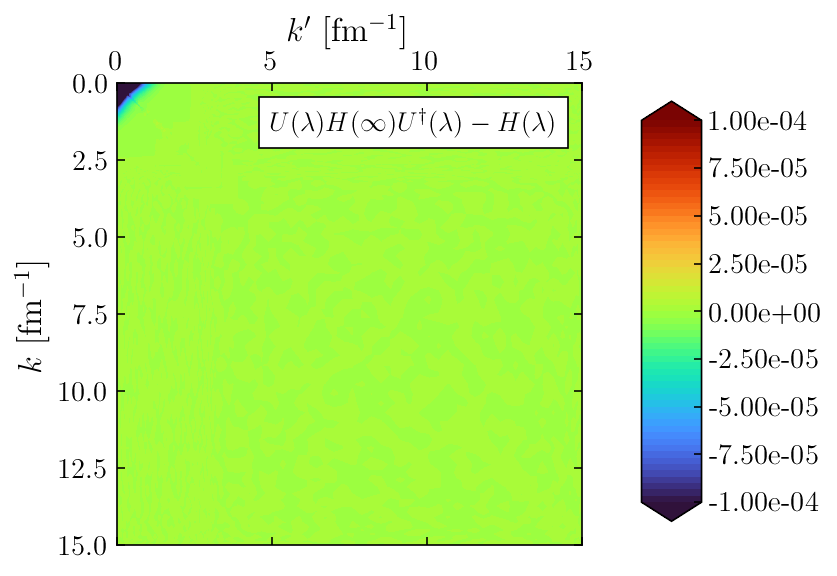

In [16]:
# Plot zero_matrix
contour_label = r"$U(\lambda) H(\infty) U^\dagger(\lambda) - H(\lambda)$"
plot_contour(
    k_array, zero_matrix_no_weights, channel, colorbar_limits=(-1e-4,1e-4),
    axes_limits=(0, 15), label=contour_label, label_size=13
)

Compare the eigenvalues of $H(\lambda)$, $U(\lambda) H(\infty) U^\dagger(\lambda)$, and $H(\infty)$.

In [17]:
eigenvalues_1, _ = la.eigh(H_evolved_weights)
eigenvalues_2, _ = la.eigh(H_evolved_weights_2)
eigenvalues_init, _ = la.eigh(H_initial_weights)

err_1 = rms_error_eigenvalues(eigenvalues_init, eigenvalues_1)
err_2 = rms_error_eigenvalues(eigenvalues_init, eigenvalues_2)

print(f"RMS error with H(\lambda) = {err_1}.")
print(f"RMS error with U H(\infty) U^\dagger = {err_2}.")

RMS error with H(\lambda) = 5.0129233958688e-07.
RMS error with U H(\infty) U^\dagger = 4.963430856430246e-12.


## Solving for $H(s)$

$$
\frac{dH}{ds} = \bigl[[H_D(s), H(s)], H(s) \bigr]
$$

### Using `scipy.integrate.ode`

In [ ]:
def matrix_to_vector(M):
    """
    Takes the upper triangle of the matrix M (including the diagonal) and
    reshapes it into a vector v.
        
    Parameters
    ----------
    M : 2-D ndarray
        Input matrix of shape (N, N).
            
    Returns
    -------
    v : 1-D ndarray
        Output vector of shape (N*(N+1)/2,).
            
    """

    # Length of matrix
    N = len(M)
    # Length of vectorized matrix
    n = int(N * (N + 1) / 2)

    # Initialize vectorized matrix
    v = np.zeros(n)

    # Algorithm for reshaping M to the vector v
    i = 0
    j = N
    for k in range(N):
        v[i:j] = M[k][k:]
        i = j
        j += N - k - 1

    return v

In [ ]:
def vector_to_matrix(v):
    """
    Takes the vector of an upper triangle matrix v and returns the full matrix
    M. Use only for symmetric matrices.
        
    Parameters
    ----------
    v : 1-D ndarray
        Input vector of shape (N*(N+1)/2,).
        
    Returns
    -------
    output : 2-D ndarray
        Output matrix of shape (N, N).
            
    """
    
    # Dimension of matrix is found by solving for the positive solution to
    # n = N(N+1)/2, where n is the length of the vector
    N = int((-1 + np.sqrt(1 + 8 * len(v))) / 2)

    # Initialize matrix
    M = np.zeros((N, N))

    # Build the upper half of matrix with the diagonal included

    # Algorithm for reshaping v to the matrix M
    i = 0
    j = N
    for k in range(N):
        M[k, k:] = v[i:j]
        i = j
        j += N - k - 1

    # Now reflect the upper half to lower half to build full matrix
    # M.T - np.diag(np.diag(M)) is the lower half of M excluding diagonal
    return M + (M.T - np.diag(np.diag(M)))

In [ ]:
def commutator(A, B):
    """Commutator of square matrices A and B."""

    return A @ B - B @ A

In [ ]:
def eta(H_matrix):
    """Wegner generator \eta = [H_D, H]."""

    # G = H_D (diagonal of the evolving Hamiltonian)
    G_matrix = np.diag(np.diag(H_matrix))

    # \eta = [G, H]
    return commutator(G_matrix, H_matrix)

In [ ]:
def H_deriv(lamb, H_vector):
    """Right-hand side of the SRG flow equation."""

    # Matrix form of the evolving Hamiltonian
    H_matrix = vector_to_matrix(H_vector)

    # Get SRG generator \eta = [G, H]
    eta_matrix = eta(H_matrix)

    # RHS of the flow equation in matrix form
    dH_matrix = -4.0 / lamb ** 5 * commutator(eta_matrix, H_matrix)

    # Returns vector form of RHS of flow equation
    dH_vector = matrix_to_vector(dH_matrix)

    return dH_vector

In [ ]:
def select_step_size(solver_lambda, lambda_final):
    """Select ODE solver step-size depending on the extent of evolution. We
    can take bigger steps at large values of \lambda.
    """

    if solver_lambda >= 6.0:
        dlamb = 1.0
    elif 2.5 <= solver_lambda < 6.0:
        dlamb = 0.5
    elif 1.5 <= solver_lambda < 2.5:
        dlamb = 0.1
    else:
        dlamb = 0.05

#     # This if statement prevents the solver from over-shooting \lambda and
#     # takes a step in \lambda equal to the exact amount necessary to reach 
#     # lambda_final
#     if solver_lambda - dlamb < lambda_final:
#         dlamb = solver_lambda - lambda_final

    return dlamb

In [ ]:
def get_ode_solver(lambda_initial, H_initial, atol, rtol):
    """Sets up the ODE solver."""

    # Solving for H(s)
    solver = ode(H_deriv)

    # Initial Hamiltonian as a vector
    H_initial = matrix_to_vector(H_initial)

    # Set initial conditions
    solver.set_initial_value(H_initial, lambda_initial)

    # Following the example in Hergert:2016iju with modifications to nsteps and
    # error tolerances
    solver.set_integrator('vode', method='bdf', order=5, atol=atol, rtol=rtol,
                          nsteps=5000000)

    return solver

In [ ]:
def srg_evolve_wrt_lambda(
        H_initial_MeV, lambda_array, lambda_initial=20.0, atol=1e-6, rtol=1e-6
):
    """SRG evolve the Hamiltonian with respect to \lambda."""
    
    # Convert Hamiltonian from MeV to units [fm^-2]
    H_initial = H_initial_MeV / 41.47

    # Set-up ODE solver
    solver = get_ode_solver(lambda_initial, H_initial, atol, rtol)
    
    # Start time
    t0 = time.time()
    
    # Evolve the Hamiltonian to each value of \lambda and store in dictionary
    d = {}
#     # TESTING
#     lambdas = []
    for lamb in lambda_array:

        # Solve ODE up to lamb and store in dictionary
        while solver.successful() and round(solver.t, 2) > lamb:
            
            # Get ODE solver step-size in \lambda
            dlamb = select_step_size(solver.t, lamb)
            
#             # TESTING
#             lambdas.append(solver.t - dlamb)
            
            # Integrate to next step in lambda
            solution_vector = solver.integrate(solver.t - dlamb)

        # Store evolved Hamiltonian matrix [MeV] in dictionary
        d[lamb] = vector_to_matrix(solution_vector) * 41.47

    # End time
    t1 = time.time()

    # Print details
    mins = round((t1 - t0) / 60.0, 4)  # Minutes elapsed evolving H(\lambda)
    print(f"Done evolving to \lambda = {lamb} fm^-1 after {mins:.4f} minutes.")
    
#     # TESTING
#     print(lambdas)
#     print(len(lambdas))

    return d

First solve with respect to $\lambda$ using `scipy.integrate.ode` as is done in the current code. Compare the eigenvalues of $H(\lambda)$ and $H(\infty)$ in each test run.

In [ ]:
lambda_array = np.array([6.0, 3.0, 2.0, 1.5, 1.35])

In [ ]:
# Default case (focus on last \lambda for now)
d = srg_evolve_wrt_lambda(H_initial_weights, lambda_array, lambda_initial=20.0)

eigenvalues_evol, _ = la.eigh(d[lamb])
err = rms_error_eigenvalues(eigenvalues_init, eigenvalues_evol)

print(f"RMS error in eigenvalues = {err}.")

In [ ]:
# Set more stringent error tolerances

# # Run SRG code
# d = run_srg(
#     kvnn, channel, generator, lambda_array, kmax, kmid, ntot, solver='ode',
#     method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda', save=True
# )
# H_evolved = d[lamb]

# Load saved file
H_evolved = load_H_evolved(
    kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='ode',
    method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda'
)

eigenvalues_evol, _ = la.eigh(H_evolved)
err = rms_error_eigenvalues(eigenvalues_init, eigenvalues_evol)

print(f"RMS error in eigenvalues = {err}.")

Repeat test on $U(\lambda)$ from before but with `atol`=$10^{-10}$ and `rtol`=$10^{-10}$.

In [ ]:
# SRG transformation with integration factors attached [unitless]
U_matrix_weights = get_transformation(H_initial_weights, H_evolved)

H_evolved_weights_2 = U_matrix_weights @ H_initial_weights @ U_matrix_weights.T
zero_matrix_weights = H_evolved_weights_2-H_evolved
print(zero_matrix_weights)
print(la.norm(zero_matrix_weights))

# Remove integration weights from zero_matrix
zero_matrix_no_weights = unattach_weights(k_array, k_weights,
                                          zero_matrix_weights)

# Plot zero_matrix
contour_label = r"$U(\lambda) H(\infty) U^\dagger(\lambda) - H(\lambda)$"
plot_contour(
    k_array, zero_matrix_no_weights, channel, colorbar_limits=(-1e-4,1e-4),
    axes_limits=(0, 15), label=contour_label, label_size=13
)

### Using `scipy.integrate.solve_ivp`

In [ ]:
def H_deriv_s(s, H_vector):
    """Right-hand side of the SRG flow equation."""

    # Matrix form of the evolving Hamiltonian
    H_matrix = vector_to_matrix(H_vector)

    # Get SRG generator \eta = [G, H]
    eta_matrix = eta(H_matrix)

    # RHS of the flow equation in matrix form
    dH_matrix = commutator(eta_matrix, H_matrix)

    # Returns vector form of RHS of flow equation
    dH_vector = matrix_to_vector(dH_matrix)

    return dH_vector

In [ ]:
def srg_evolve_solve_ivp(
        H_initial_MeV, lambda_array, method='BDF', atol=1e-10, rtol=1e-10,
        wrt='s'
):
    """SRG evolve the Hamiltonian with respect to s."""
    
    # Convert Hamiltonian from MeV to units [fm^-2]
    H_initial_matrix = H_initial_MeV / 41.47

    # Reshape H_initial into vector
    H_initial_vector = matrix_to_vector(H_initial_matrix)
    
    # Start time
    t0 = time.time()
    
    # Solve w.r.t. s
    if wrt == 's':
        
        # Evaluate at the following s points
        s_array = lambda_array ** (-4)
        s_limits = [0.0, s_array[-1]]
    
        result = solve_ivp(H_deriv_s, s_limits, H_initial_vector, method=method,
                           t_eval=s_array, atol=atol, rtol=rtol)
    
    # Solve w.r.t. \lambda
    else:
    
        # Set initial \lambda to 20 fm^-1 (this is sufficiently large)
        lamb_limits = [20.0, lambda_array[-1]]
    
        result = solve_ivp(
            H_deriv, lamb_limits, H_initial_vector, method=method,
            t_eval=lambda_array, atol=atol, rtol=rtol
        )
    
#         result = solve_ivp(
#             H_deriv, lamb_limits, H_initial_vector, method=method,
#             t_eval=None, atol=atol, rtol=rtol
#         )
    
    # End time
    t1 = time.time()
    
    # Print details
    mins = round((t1 - t0) / 60.0, 4)  # Minutes elapsed evolving H(s)
    print(f"Done evolving to \lambda = {lambda_array[-1]} fm^-1 after "
          f"{mins:.4f} minutes.")
    
    # Store evolved Hamiltonian matrix [MeV] in dictionary
    d = {}
    for i, lamb in enumerate(lambda_array):
        d[lamb] = vector_to_matrix(result.y[:, i]) * 41.47
        
#     # TESTING
#     print(result.t)
#     print(len(result.t))

    return d

In [ ]:
# Use solve_ivp w.r.t. s using BDF

# # Run SRG code
# d = run_srg(
#     kvnn, channel, generator, lambda_array, kmax, kmid, ntot,
#     solver='solve_ivp', method='BDF', atol=1e-10, rtol=1e-10, wrt='s',
#     save=True
# )
# H_evolved = d[lamb]

# Load saved file
H_evolved = load_H_evolved(
    kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='solve_ivp',
    method='BDF', atol=1e-10, rtol=1e-10, wrt='s',
)

eigenvalues_evol, _ = la.eigh(H_evolved)
err = rms_error_eigenvalues(eigenvalues_init, eigenvalues_evol)

print(f"RMS error in eigenvalues = {err}.")

In [ ]:
# Use solve_ivp w.r.t. s using LSODA

# # Run SRG code
# d = run_srg(
#     kvnn, channel, generator, lambda_array, kmax, kmid, ntot,
#     solver='solve_ivp', method='LSODA', atol=1e-10, rtol=1e-10, wrt='s',
#     save=True
# )
# H_evolved = d[lamb]

# Load saved file
H_evolved = load_H_evolved(
    kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='solve_ivp',
    method='LSODA', atol=1e-10, rtol=1e-10, wrt='s',
)

eigenvalues_evol, _ = la.eigh(H_evolved)
err = rms_error_eigenvalues(eigenvalues_init, eigenvalues_evol)

print(f"RMS error in eigenvalues = {err}.")

In [ ]:
# Use solve_ivp w.r.t. \lambda using LSODA

# # Run SRG code
# d = run_srg(
#     kvnn, channel, generator, lambda_array, kmax, kmid, ntot,
#     solver='solve_ivp', method='LSODA', atol=1e-10, rtol=1e-10, wrt='lambda',
#     save=True
# )
# H_evolved = d[lamb]

# Load saved file
H_evolved = load_H_evolved(
    kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='solve_ivp',
    method='LSODA', atol=1e-10, rtol=1e-10, wrt='lambda',
)

eigenvalues_evol, _ = la.eigh(H_evolved)
err = rms_error_eigenvalues(eigenvalues_init, eigenvalues_evol)

print(f"RMS error in eigenvalues = {err}.")

## Solve for $U(s)$ directly

$$
\frac{dU}{ds} = \eta(s) U(s)
$$

In [ ]:
def U_deriv_s(s, U_vector, H_initial):
    """Right-hand side of dU/ds = \eta(s) U(s)."""
    
    # Dimension of the Hamiltonian
    Ntot = len(H_initial)
    
    # Change U_vector into matrix form
    U_matrix = np.reshape(U_vector, (Ntot, Ntot))
    
    # Compute H(s) = U(s) H(\infty) U^\dagger(s)
    H_evolved = U_matrix @ H_initial @ U_matrix.T
    
    # Compute \eta(s) = [H_D(s), H(s)]
    eta_matrix = eta(H_evolved)
    
    # Compute RHS dU/ds = \eta(s) U(s)
    dU_matrix = eta_matrix @ U_matrix
    
    # Return vector of the RHS
    return np.reshape(dU_matrix, -1)

In [ ]:
def U_deriv_lambda(lamb, U_vector, H_initial):
    """RHS of dU/d\lambda = -4/\lambda^5 \eta(\lambda) U(\lambda)."""
    
    # Dimension of the Hamiltonian
    Ntot = len(H_initial)
    
    # Change U_vector into matrix form
    U_matrix = np.reshape(U_vector, (Ntot, Ntot))
    
    # Compute H(\lambda) = U(\lambda) H(\infty) U^\dagger(\lambda)
    H_evolved = U_matrix @ H_initial @ U_matrix.T
    
    # Compute \eta(\lambda) = [H_D(\lambda), H(\lambda)]
    eta_matrix = eta(H_evolved)
    
    # Compute RHS dU/d\lambda = -4/\lambda^5 \eta(\lambda) U(\lambda)
    dU_matrix = -4.0 / lamb ** 5 * eta_matrix @ U_matrix
    
    # Return vector of the RHS
    return np.reshape(dU_matrix, -1)

In [ ]:
def get_ode_solver_U(lambda_initial, H_initial, atol, rtol):
    """Sets up the ODE solver."""

    # Solving for U(s)
    solver = ode(U_deriv_lambda)
    solver.set_f_params(H_initial)
    
    Ntot = len(H_initial)
    # Initial SRG transformation as a matrix
    U_initial = np.eye(Ntot)

    # Initial SRG transformation as a vector
    U_initial_vector  = np.reshape(U_initial, -1)

    # Set initial conditions
    solver.set_initial_value(U_initial_vector, lambda_initial)

    # Following the example in Hergert:2016iju with modifications to nsteps and
    # error tolerances
    solver.set_integrator('vode', method='bdf', order=5, atol=atol, rtol=rtol,
                          nsteps=5000000)

    return solver

In [ ]:
def srg_evolve_U_lambda(
        H_initial_MeV, lambda_array, lambda_initial=20.0, atol=1e-10, rtol=1e-10
):
    """SRG evolve the SRG transformation with respect to \lambda."""
    
    # Convert Hamiltonian from MeV to units [fm^-2]
    H_initial = H_initial_MeV / 41.47
    Ntot = len(H_initial)

    # Set-up ODE solver
    solver = get_ode_solver_U(lambda_initial, H_initial, atol, rtol)
    
    # Start time
    t0 = time.time()
    
    # Evolve the SRG transformation to each value of \lambda and store in
    # dictionary
    d = {}
    for lamb in lambda_array:
        
        d[lamb] = {}

        # Solve ODE up to lamb and store in dictionary
        while solver.successful() and round(solver.t, 2) > lamb:
            
            # Get ODE solver step-size in \lambda
            dlamb = select_step_size(solver.t, lamb)
            
            # Integrate to next step in lambda
            solution_vector = solver.integrate(solver.t - dlamb)

        # Get SRG transformation matrix
        U_matrix = np.reshape(solution_vector, (Ntot, Ntot))
        d[lamb]['U'] = U_matrix
        # Store evolved Hamiltonian matrix [MeV] in dictionary
        d[lamb]['H'] = U_matrix @ H_initial @ U_matrix.T * 41.47

    # End time
    t1 = time.time()

    # Print details
    mins = round((t1 - t0) / 60.0, 4)  # Minutes elapsed evolving H(\lambda)
    print(f"Done evolving to \lambda = {lamb} fm^-1 after {mins:.4f} minutes.")
    
    return d

In [ ]:
# Use ode w.r.t. \lambda using BDF to solve for U(\lambda)

# # Run SRG code
# d = run_srg(
#     kvnn, channel, generator, lambda_array, kmax, kmid, ntot, solver='U',
#     method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda', save=True
# )
# H_evolved = d[lamb]

# Load saved file
H_evolved, U_evolved = load_H_evolved(
    kvnn, channel, generator, lamb, kmax, kmid, ntot, solver='U', method='BDF',
    atol=1e-10, rtol=1e-10, wrt='lambda'
)

eigenvalues_evol, _ = la.eigh(H_evolved)
err = rms_error_eigenvalues(eigenvalues_init, eigenvalues_evol)

print(f"RMS error in eigenvalues = {err}.")

## Diagonal and far-off-diagonal slices of $V(\infty)$ and $V(\lambda)$

In [ ]:
def plot_potentials(
        kvnn, channel, kmax, kmid, ntot, generator, lambda_array,
        x_limits=(0.0,15.0), y_limits=(-4.0,2.0), xlabel_size=16,
        ylabel_size=16
):
    """Plot diagonal slices of V(\infty) and V(\lambda)."""
    
    if channel in ['3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1']:
        channel_arg = '3S1'
    elif channel in ['3P2-3P2', '3P2-3F2', '3F2-3P2', '3F2-3F2']:
        channel_arg = '3P2'
    else:
        channel_arg = channel
    
    # --- Figure set-up --- #
    plt.close('all')
    row_number = 1
    col_number = 2
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(8, 4))
    
    # --- Get data --- #  
    # Initialize potential object and get its momentum mesh
    potential = Potential(kvnn, channel_arg, kmax, kmid, ntot)
    k_array, _ = potential.load_mesh()  # fm^-1
    
    V_initial = potential.load_potential()  # fm
    T_matrix = potential.load_kinetic_energy()  # MeV
    
    # Get specific sub-block if coupled-channel
    if channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
        V_initial = V_initial[:ntot,ntot:]
    elif channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
        V_initial = V_initial[ntot:,:ntot]
    elif channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
        V_initial = V_initial[ntot:,ntot:]
    else:
        V_initial = V_initial[:ntot,:ntot]
        
    # Index of off-diagonal k value in k_array
    # Add a curve for each \lambda
    for i, lamb in enumerate(lambda_array):
        
        # SRG-evolved with block-diagonal generator
        # V_matrix = potential.load_potential('srg', generator, lamb)
#         H_evolved = load_H_evolved(
#             kvnn, channel_arg, generator, lamb, kmax, kmid, ntot, solver='ode',
#             method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda'
#         )
        _, U_evolved = load_H_evolved(
            kvnn, channel_arg, generator, lamb, kmax, kmid, ntot, solver='U',
            method='BDF', atol=1e-10, rtol=1e-10, wrt='lambda'
        )
        H_evolved = U_evolved @ potential.load_hamiltonian() @ U_evolved.T
        V_evolved_MeV = H_evolved - T_matrix  # MeV
        V_evolved = potential.convert_V_to_fm(V_evolved_MeV)  # MeV -> fm
            
        # Get specific sub-block if coupled-channel
        if channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
            V_matrix = V_evolved[:ntot,ntot:]
        elif channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
            V_matrix = V_evolved[ntot:,:ntot]
        elif channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
            V_matrix = V_evolved[ntot:,ntot:]
        else:
            V_matrix = V_evolved[:ntot,:ntot]
        
        # --- Plot --- #
        lambda_label = label_lambda(lamb, generator)
        
        # Plot diagonal matrix elements on left column
        axs[0].plot(k_array, np.diag(V_matrix), label=lambda_label,
                    linewidth=2.0)
        
        # Plot off-diagonal matrix elements on right column
        axs[1].plot(k_array, V_matrix[:, 0], label=lambda_label, linewidth=2.0)
        
        print(f"V(kmax, kmax) at \lambda = {lamb} = {np.diag(V_matrix)[-1]}.")
    print(f"V(kmax, kmax) unevolved = {np.diag(V_initial)[-1]}.")
        
    # Plot initial potential
    lambda_label = label_lambda(np.inf, generator)
    axs[0].plot(k_array, np.diag(V_initial), 'k:', label=lambda_label,
                linewidth=2.0)
    axs[1].plot(k_array, V_initial[:, 0], 'k:', label=lambda_label,
                linewidth=2.0)

    # --- Axes limits --- #
    axs[0].set_xlim(x_limits)
    axs[0].set_ylim(y_limits)
    axs[1].set_xlim(x_limits)
    axs[1].set_ylim(y_limits)
                    
    # --- Axes labels --- #
    # Label x-axis on bottom row
    axs[0].set_xlabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    axs[1].set_xlabel("$k$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
                    
    # Label y-axis on left column
    axs[0].set_ylabel(r"$V(k,k)$ [fm]", fontsize=ylabel_size)
    axs[1].set_ylabel(rf"$V(k,{k_array[0]:.5f})$ [fm]", fontsize=ylabel_size)

    # --- Adjust axes --- #                      
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.05, wspace=0.18)

    # --- Legends --- #
    # Label kvnns on top row
    # axs[0].legend(loc='lower right', fontsize=14, frameon=False)
    # Label generators on bottom row
    # axs[1].legend(loc='lower right', fontsize=12, frameon=False)
    axs[1].legend(fontsize=12, frameon=False)

    # --- Additional labels --- #
    # Label partial wave channel in last sub-plot
    axs[0].set_title(channel)
    axs[1].set_title(channel)

### Set-up

In [ ]:
lambda_array = np.array([6.0, 3.0, 2.0, 1.35])

In [ ]:
# 1S0
plot_potentials(kvnn, '1S0', kmax, kmid, ntot, generator, lambda_array,
                x_limits=(0, kmax), y_limits=(-2.3, 1.3))

In [ ]:
# 3S1-3S1
plot_potentials(kvnn, '3S1-3S1', kmax, kmid, ntot, generator, lambda_array,
                x_limits=(0, kmax), y_limits=(-3.4, 1.3))

In [ ]:
# 3S1-3D1
plot_potentials(kvnn, '3S1-3D1', kmax, kmid, ntot, generator, lambda_array,
                x_limits=(0, kmax), y_limits=(-0.4, 0.1))

In [ ]:
# 3D1-3D1
plot_potentials(kvnn, '3D1-3D1', kmax, kmid, ntot, generator, lambda_array,
                x_limits=(0, kmax), y_limits=(-0.1, 0.3))

In [ ]:
# # 3P2-3P2
# plot_potentials(kvnn, '3P2-3P2', kmax, kmid, ntot, generator, lambda_array,
#                 x_limits=(0, kmax), y_limits=(-0.2, 0.15))

## Testing updated `srg.py`

In [18]:
from scripts.srg import SRG, compute_srg_transformation

In [19]:
lambda_array = np.array([6.0, 4.0, 3.0, 2.5, 2.0, 1.5, 1.35])
lamb = lambda_array[-1]

In [20]:
# SMS N4LO 450 MeV 1S0 initial
srg_1S0 = SRG(111, '1S0', 15.0, 3.0, 120, 'Wegner')
H_initial_1S0 = srg_1S0.load_hamiltonian()
eigenvalues_initial_1S0, _ = la.eigh(H_initial_1S0)

In [21]:
# SMS N4LO 450 MeV 3S1-3D1 initial
srg_3S1 = SRG(111, '3S1', 15.0, 3.0, 120, 'Wegner')
H_initial_3S1 = srg_3S1.load_hamiltonian()
eigenvalues_initial_3S1, _ = la.eigh(H_initial_3S1)

In [22]:
# SRG-evolving H(\lambda) for SMS N4LO 450 MeV 1S0
d = srg_1S0.srg_evolve(lambda_array, method='hamiltonian', save=True)
eigenvalues_evolved_1S0, _ = la.eigh(d[lamb]*41.47)
rms_error_eigenvalues(eigenvalues_initial_1S0, eigenvalues_evolved_1S0)

_____________________________________________________________________________________
Done evolving to final \lambda = 1.35 fm^-1 after 0.9752 minutes.
_____________________________________________________________________________________

Specifications:

kvnn = 111, channel = 1S0
kmax = 15.0, kmid = 3.0, ntot = 120
method = SRG, generator = Wegner


1.2266153133151528e-07

In [23]:
# SRG-evolving H(\lambda) for SMS N4LO 450 MeV 3S1-3D1
d = srg_3S1.srg_evolve(lambda_array, method='hamiltonian', save=True)
U_matrix_1 = compute_srg_transformation(H_initial_3S1, d[lamb]*41.47)
eigenvalues_evolved_3S1, _ = la.eigh(d[lamb]*41.47)
rms_error_eigenvalues(eigenvalues_initial_3S1, eigenvalues_evolved_3S1)

_____________________________________________________________________________________
Done evolving to final \lambda = 1.35 fm^-1 after 3.5312 minutes.
_____________________________________________________________________________________

Specifications:

kvnn = 111, channel = 3S1
kmax = 15.0, kmid = 3.0, ntot = 120
method = SRG, generator = Wegner


4.5518884150467e-07

In [24]:
# SRG-evolving U(\lambda) for SMS N4LO 450 MeV 1S0
d = srg_1S0.srg_evolve(lambda_array, method='srg_transformation', save=True)
eigenvalues_evolved_1S0, _ = la.eigh(d[lamb] @ H_initial_1S0 @ d[lamb].T)
rms_error_eigenvalues(eigenvalues_initial_1S0, eigenvalues_evolved_1S0)

_____________________________________________________________________________________
Done evolving to final \lambda = 1.35 fm^-1 after 0.9519 minutes.
_____________________________________________________________________________________

Specifications:

kvnn = 111, channel = 1S0
kmax = 15.0, kmid = 3.0, ntot = 120
method = SRG, generator = Wegner


5.015779000768689e-06

In [25]:
# SRG-evolving U(\lambda) for SMS N4LO 450 MeV 3S1-3D1
d = srg_3S1.srg_evolve(lambda_array, method='srg_transformation', save=True)
U_matrix_2 = srg_3S1.load_srg_transformation(lamb)
eigenvalues_evolved_3S1, _ = la.eigh(d[lamb] @ H_initial_3S1 @ d[lamb].T)
rms_error_eigenvalues(eigenvalues_initial_3S1, eigenvalues_evolved_3S1)

_____________________________________________________________________________________
Done evolving to final \lambda = 1.35 fm^-1 after 3.0569 minutes.
_____________________________________________________________________________________

Specifications:

kvnn = 111, channel = 3S1
kmax = 15.0, kmid = 3.0, ntot = 120
method = SRG, generator = Wegner


5.868937597956269e-06

In [26]:
# Testing block-diagonal evolution
srg_1S0_BD = SRG(111, '1S0', 15.0, 3.0, 120, 'Block-diag')
d = srg_1S0_BD.srg_evolve(lambda_array, lambda_array,
                          method='srg_transformation', save=True)
eigenvalues_evolved_1S0, _ = la.eigh(
    d[3.0][lamb] @ H_initial_1S0 @ d[3.0][lamb].T
)
rms_error_eigenvalues(eigenvalues_initial_1S0, eigenvalues_evolved_1S0)

_____________________________________________________________________________________
Done evolving to final \lambda = 1.35 fm^-1 after 9.9463 minutes.
_____________________________________________________________________________________

Specifications:

kvnn = 111, channel = 1S0
kmax = 15.0, kmid = 3.0, ntot = 120
method = SRG, generator = Block-diag
Final \Lambda_BD = 1.35 fm^-1


3.185278278378581e-06

In [27]:
print(U_matrix_1-U_matrix_2)

[[-4.43429404e-10  3.75737805e-09  1.85284574e-09 ... -3.86597872e-15
  -6.05172614e-15 -4.81271538e-12]
 [-3.75742189e-09 -2.84283103e-08  1.79457644e-08 ... -3.06657256e-14
  -4.82870051e-14 -3.83217951e-11]
 [-1.85302229e-09 -1.79472508e-08  3.13606590e-08 ... -9.06272503e-14
  -1.41800782e-13 -1.12786559e-10]
 ...
 [ 9.96878691e-16  7.82004196e-15  2.32416501e-14 ... -1.68104414e-08
   1.09635925e-09  6.11515564e-10]
 [ 4.89657067e-15  3.89076423e-14  1.14664091e-13 ... -9.34662945e-10
  -2.18111484e-09  6.47948304e-10]
 [ 4.81235612e-12  3.83189840e-11  1.12777584e-10 ... -6.15662384e-10
  -5.54172801e-10 -2.63194496e-08]]
